# 考察
１．前回からの変更点  
・usd_goal_realをperiod（deadline-launched）で除した変数gpratioを説明変数に追加し、使用した二変数は削除  
・変数にcategoryを追加  
・ステップワイズ法による変数選択を実施  
・汎化性能をロジスティック回帰とランダムフォレストで評価（評価指標はAccuracy）  
２．結果  
・前回の訓練誤差63.13%および汎化性能63.53%から、訓練誤差65.42%および汎化性能65.60%と、いずれも約2%向上した 

In [1]:
#使用するライブラリを一括インポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import codecs as cd
import os
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score, precision_recall_fscore_support, confusion_matrix 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import RFECV
from sklearn.linear_model import SGDClassifier
import warnings
warnings.filterwarnings('ignore')

In [3]:
#データを読み込んで内容を確認

##読み込むデータのパスを指定
os.chdir("C:\Anaconda3\envs\skillupai\Dataset")

##使用するデータの読み込み
ds=pd.read_csv("Kaggle_SkillupAI.csv", engine="python")

##データの表示
ds


,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.00,failed,0,GB,0.00,0.00,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.00,failed,15,US,100.00,2421.00,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.00,failed,3,US,220.00,220.00,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.00,failed,1,US,1.00,1.00,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.00,canceled,14,US,1283.00,1283.00,19500.00
5,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,52375.00,successful,224,US,52375.00,52375.00,50000.00
6,1000023410,Support Solar Roasted Coffee & Green Energy! ...,Food,Food,USD,2014-12-21,1000.0,2014-12-01 18:30:44,1205.00,successful,16,US,1205.00,1205.00,1000.00
7,1000030581,Chaser Strips. Our Strips make Shots their B*tch!,Drinks,Food,USD,2016-03-17,25000.0,2016-02-01 20:05:12,453.00,failed,40,US,453.00,453.00,25000.00
8,1000034518,SPIN - Premium Retractable In-Ear Headphones w...,Product Design,Design,USD,2014-05-29,125000.0,2014-04-24 18:14:43,8233.00,canceled,58,US,8233.00,8233.00,125000.00
9,100004195,STUDIO IN THE SKY - A Documentary Feature Film...,Documentary,Film & Video,USD,2014-08-10,65000.0,2014-07-11 21:55:48,6240.57,canceled,43,US,6240.57,6240.57,65000.00


In [8]:
#データの前処理

##使用しない変数を削除
drop_col=['ID','name','currency','pledged','backers','usd pledged','usd_pledged_real','goal']
ds_use=ds.drop(drop_col, axis=1)

##開始日と締切日の間の日数を新たにperiodという変数として定義する
ds_use['deadline'] = pd.to_datetime(ds_use['deadline'], errors = 'coerce')
ds_use['launched'] = pd.to_datetime(ds_use['launched'], errors = 'coerce')
ds_use['period'] = (ds_use['deadline'] - ds_use['launched']).dt.days
ds_use = ds_use.drop(['deadline', 'launched'], axis=1)

##カテゴリ変数をダミー変数に変換して結合する

###ダミー変数を取得する
ds_dummy_cate = pd.get_dummies(ds_use['category'])
ds_dummy_maincate = pd.get_dummies(ds_use['main_category'])
ds_dummy_cou = pd.get_dummies(ds_use['country'])

#ダミー変数を結合する
ds_use = pd.concat([ds_use.drop(['category', 'main_category','country'],axis=1),ds_dummy_cate,ds_dummy_maincate,ds_dummy_cou],axis=1)

##usd_goal_realを対数変換する
log_usd=np.log(ds_use['usd_goal_real'])
ds_use = pd.concat([ds_use.drop(['usd_goal_real'],axis=1),log_usd],axis=1)

##usd_goal_realをperiodで除した指標を新たに定義する

ds_use['gpratio'] = ds_use["period"]/ds_use["usd_goal_real"]
ds_use = ds_use.drop(['period', 'usd_goal_real'], axis=1)

##periodとusd_goal_realの外れ値（四分位範囲外の値）を削除する
col1=ds_use['gpratio']
q1 = col1.describe()['25%']
q3 = col1.describe()['75%']
iqr=q3-q1
outlier_min1 = q1 - (iqr) * 1.5
outlier_max1 = q3 + (iqr) * 1.5
col1[col1 < outlier_min1] = None
col1[col1 > outlier_max1] = None

ds_use['gpratio']=col1

#欠損値を含む行の削除
ds_use = ds_use.dropna(how='any')

##stateがsuccessfulとfailed以外のデータを削除
ds_suc=ds_use[ds_use['state']=='successful']
ds_not=ds_use[(ds_use['state']=='failed')]
ds_sum=pd.concat([ds_suc, ds_not])

##行をランダムに並び替え
ds_sum = ds_sum.sample(frac=1)
ds_sum

,state,3D Printing,Academic,Accessories,Action,Animals,Animation,Anthologies,Apparel,Apps,...,LU,MX,"N,0""",NL,NO,NZ,SE,SG,US,gpratio
48936,failed,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,5.723181
282270,failed,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,3.431850
66437,failed,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,3.226813
339877,failed,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2.875974
222521,failed,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2.586556
257530,failed,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3.097505
130657,failed,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,6.733006
242442,failed,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2.129410
188712,failed,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,6.135731
173826,successful,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,3.007095


In [10]:
#ステップワイズ法で特徴量選択

#特徴量選択を実行
rfecv=RFECV(LogisticRegression(), cv=5, scoring="accuracy")
train_label=ds_sum["state"]
train_data=ds_sum.drop('state', axis=1)
y=train_label.values
X=train_data.values
rfecv.fit(X,y)

RFECV(cv=5,
      estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                   fit_intercept=True, intercept_scaling=1,
                                   l1_ratio=None, max_iter=100,
                                   multi_class='warn', n_jobs=None,
                                   penalty='l2', random_state=None,
                                   solver='warn', tol=0.0001, verbose=0,
                                   warm_start=False),
      min_features_to_select=1, n_jobs=None, scoring='accuracy', step=1,
      verbose=0)

Feature ranking: 
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1
 1 1 1 1 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 5 1 1 1 1 1 1 1 1 1]


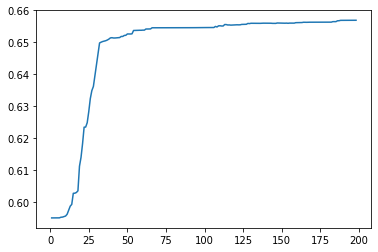

,state,3D Printing,Academic,Accessories,Action,Animals,Animation,Anthologies,Apparel,Apps,...,JP,MX,"N,0""",NL,NO,NZ,SE,SG,US,gpratio
48936,failed,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,5.723181
282270,failed,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,3.431850
66437,failed,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,3.226813
339877,failed,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2.875974
222521,failed,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2.586556
257530,failed,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3.097505
130657,failed,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,6.733006
242442,failed,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2.129410
188712,failed,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,6.135731
173826,successful,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,3.007095


In [11]:
## 特徴量の重要ランキングを表示
print('Feature ranking: \n{}'.format(rfecv.ranking_))
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

#削除する特徴量のインデックスを取得
remove_idx = ~rfecv.support_
add = np.array([0], dtype=bool)
remove_idx=np.append(add, remove_idx)
remove_idx

##削除するインデックス名を取得
remove_feature = ds_sum.columns[remove_idx]
remove_feature

##関係の無い特徴量を削除
ds_sum = ds_sum.drop(remove_feature, axis=1)
ds_sum

In [12]:
#ロジスティック回帰とランダムフォレストを実行し、訓練誤差およびクロスバリデーションで汎化性能を評価

##ロジスティック回帰を実行して訓練誤差と汎化誤差を確認

###訓練誤差の確認
y = ds_sum["state"].values
X = ds_sum.drop("state", axis=1).values
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
clf.fit(X, y)
y_pred = clf.predict(X)
accuracy =  accuracy_score(y, y_pred)
print('正答率（訓練） = {:.3f}%'.format(100 * accuracy))

###クロスバリデーションで汎化性能の確認
logreg = LogisticRegression()
scores = cross_val_score(logreg, ds_sum.drop("state", axis=1).values, ds_sum["state"].values, cv=5)
print('正答率（テスト、ロジ）: {}'.format(scores))
print('平均正答率（テスト、ロジ）: {}'.format(np.mean(scores)))

##ランダムフォレストを実行して汎化性能を確認

###クロスバリデーションで汎化性能の確認
romFo = RandomForestClassifier()
scores = cross_val_score(romFo, ds_sum.drop("state", axis=1).values, ds_sum["state"].values, cv=5)
print('正答率（テスト、ランフォ）: {}'.format(scores))
print('平均正答率（テスト、ランフォ）: {}'.format(np.mean(scores)))

正答率（訓練） = 65.415%
正答率（テスト、ロジ）: [0.65597465 0.65645967 0.65887926 0.65453017 0.65878225]
平均正答率（テスト、ロジ）: 0.6569252006909395
正答率（テスト、ランフォ）: [0.6215705  0.62281538 0.62107935 0.62234043 0.62434521]
平均正答率（テスト、ランフォ）: 0.622430174009304
